In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import unicodedata
import scipy.stats
import copy
from string import punctuation

In [ ]:
#how many single-xxx, multi-xxx, and no-xxx child utterances are in Providence? 
# how many tokens does the first case correspond to
# of these, how many are monosyllabic phono vs. multi-syllabic phono

In [2]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [3]:
phono_glosses = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where \
    actual_phonology != "" and model_phonology != "" and collection_name = "Eng-NA" \
    and corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")

R[write to console]: Using supported database version: '2020.1'.



In [4]:
phono_glosses.corpus_name.value_counts()

Providence    396621
Name: corpus_name, dtype: int64

In [5]:
phono_glosses.loc[phono_glosses.gloss == 'xxx'].actual_phonology.value_counts()

*       26736
ə          10
(.)         7
aɪ          4
hiɡh        2
        ...  
ɪʔ          1
dʒeɪ        1
ɑdəʃ        1
eɪ          1
ɪs          1
Name: actual_phonology, Length: 76, dtype: int64

Actual phonology is almost always * for xxx items

In [6]:
phono_glosses.loc[phono_glosses.gloss == 'yyy'].actual_phonology.value_counts()

ɛ         3206
ʌ         2132
ɪ         1881
ə          512
o          507
          ... 
aɪtɪ         1
wʊdidə       1
neɪ̃ŋ        1
dwɛdə        1
tɛðæ         1
Name: actual_phonology, Length: 30293, dtype: int64

Actual phonology is populated for yyy items

In [7]:
chi_phono = phono_glosses.loc[(phono_glosses.speaker_code == 'CHI') & 
    (phono_glosses.target_child_age < (365*5))]

In [8]:
def count_transmission_errors(utt_vector, error_codes):
    return(np.sum([x in error_codes for x in  utt_vector]))

In [9]:
xxxs_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['xxx'])).reset_index()
xxxs_per_utt.columns = ['utterance_id', 'num_xxx']
yyys_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['yyy'])).reset_index()
yyys_per_utt.columns = ['utterance_id', 'num_yyy']
failures_per_utt = xxxs_per_utt.merge(yyys_per_utt)

In [10]:
yyy_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  (failures_per_utt.num_yyy == 1)]

In [11]:
yyy_utts.shape

(31457, 3)

In [12]:
success_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  
    (failures_per_utt.num_yyy == 0)]

In [13]:
success_utts.shape

(83880, 3)

In [14]:
tokens_from_errorless_utts = chi_phono.loc[chi_phono.utterance_id.isin(success_utts.utterance_id)]

In [15]:
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
tokens_from_errorless_utts = tokens_from_errorless_utts.loc[~(tokens_from_errorless_utts.actual_phonology.isin(excludes) |
    tokens_from_errorless_utts.model_phonology.isin(excludes))]

In [16]:
tokens_from_errorless_utts.shape

(214239, 12)

In [17]:
tokens_from_errorless_utts.actual_phonology

1          ɑmɪ
3          wiː
4          wiː
5           uː
52           ɛ
          ... 
396606       o
396607     waɪ
396608     liʔ
396609       ɪ
396610    hɪpo
Name: actual_phonology, Length: 214239, dtype: object

In [ ]:
# 31,760 transmission errors (from 31,760 utterances)
# 271,272 transmission successes (from 111,812 utterances)

# Prevalence of communication failures by age 

In [18]:
error_codes = ('xxx','yyy','zzz')

In [19]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

In [20]:
error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [21]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



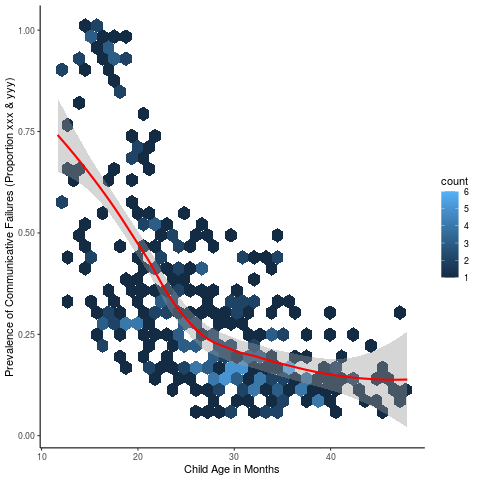

In [22]:
%%R 
ggplot(subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')) + geom_hex(aes(x=target_child_age_months, 
y=proportion_errors)) + theme_classic() + xlab('Child Age in Months') + ylab(
'Prevalence of Communicative Failures (Proportion xxx & yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors), color= 'red')

In [23]:
## why are there 0-prop ones so early? What are these transcripts?
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 20)
    & (error_prop_per_transcript.proportion_errors == 0) & (error_prop_per_transcript.num_tokens
    > 20 )]

,transcript_id,proportion_errors,target_child_age_months,num_tokens,corpus_name


In [24]:
chi_phono.loc[chi_phono.transcript_id == 41294]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months


In [25]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

,transcript_id,proportion_errors,target_child_age_months,num_tokens,corpus_name
1,42205,0.957921,17.358607,404.0,Providence
3,42207,0.984102,18.422131,629.0,Providence
105,42309,0.987281,14.889344,629.0,Providence
106,42310,0.964765,15.723361,596.0,Providence
107,42311,0.972868,15.395492,774.0,Providence
108,42312,0.995136,15.821721,1028.0,Providence
270,42474,1.000000,14.430328,187.0,Providence
271,42475,1.000000,15.264344,278.0,Providence
272,42476,0.996466,15.821721,283.0,Providence
273,42477,1.000000,16.196721,72.0,Providence


In [26]:
chi_phono.loc[chi_phono.transcript_id == 42205]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months
268,yyy,Alex,529.4375,CHI,ʌ̃,*,42205,16759608,1,Providence,Eng-NA,eng,17.358607
269,yyy,Alex,529.4375,CHI,ɡæpɪð,*,42205,16759608,2,Providence,Eng-NA,eng,17.358607
270,yyy,Alex,529.4375,CHI,ʌ,*,42205,16759643,1,Providence,Eng-NA,eng,17.358607
271,yyy,Alex,529.4375,CHI,ɪ,*,42205,16759643,2,Providence,Eng-NA,eng,17.358607
272,yyy,Alex,529.4375,CHI,ɪ,*,42205,16759643,3,Providence,Eng-NA,eng,17.358607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,yyy,Alex,529.4375,CHI,ʒoʒ,*,42205,16773756,1,Providence,Eng-NA,eng,17.358607
668,yyy,Alex,529.4375,CHI,hukwɛz,*,42205,16773767,1,Providence,Eng-NA,eng,17.358607
669,yyy,Alex,529.4375,CHI,wɔ̃,*,42205,16773783,1,Providence,Eng-NA,eng,17.358607
670,yyy,Alex,529.4375,CHI,ʃuɛː,*,42205,16773783,2,Providence,Eng-NA,eng,17.358607


# Load Models

In [31]:
from pytorch_pretrained_bert import BertForMaskedLM
from transformers import BertTokenizer # DO NOT load the one from pytorch_pretrained_bert;
# it does not support adding new vocabulary

In [27]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [28]:
cmu_in_childes = pd.read_csv('phon/cmu_in_childes.csv')

In [29]:
cmu_2syl_inchildes = cmu_in_childes.loc[cmu_in_childes.num_vowels <=2]

In [32]:
adult_bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
adult_bertMaskedLM.eval()
adult_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
adult_softmax_mask, adult_vocab = transfomers_bert_completions.get_softmax_mask(adult_tokenizer, cmu_2syl_inchildes.word)

ft1_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output')
ft1_bertMaskedLM.eval()
ft1_tokenizer = BertTokenizer.from_pretrained('model_output')
ft1_softmax_mask, ft1_vocab = transfomers_bert_completions.get_softmax_mask(ft1_tokenizer, cmu_2syl_inchildes.word)

ft2_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output2')
ft2_bertMaskedLM.eval()
ft2_tokenizer = BertTokenizer.from_pretrained('model_output2')
ft2_softmax_mask, ft2_vocab = transfomers_bert_completions.get_softmax_mask(ft2_tokenizer, cmu_2syl_inchildes.word)

# Run Actual Sents Through BERT for Prediction

In [33]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [34]:
regenerate = False

if regenerate:
    utt_glosses = childespy.get_sql_query('select gloss, transcript_id, id, \
    utterance_order, speaker_code, type from utterance where corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")
    utt_glosses.to_csv('csv/pvd_utt_glosses.csv', index=False)
else: 
    utt_glosses = pd.read_csv('csv/pvd_utt_glosses.csv')

In [35]:
# would be better to split these glosses, but then we lose the alignment 
def fix_gloss(gloss):
    return(str(gloss).replace('+','').replace('_',''))

utt_glosses.gloss = [fix_gloss(x) for x in utt_glosses.gloss]

punct_for_type = {
    'question':'?',
    'declarative':'.',
    'self interruption':'.',
    'interruption':'!',
    'trail off':'...',
    'interruption question':'?',
    'trail off question':'?',
    'imperative_emphatic':'!' 
}

utt_glosses['punct'] = [punct_for_type[x] if x in punct_for_type else '.'
                        for x in utt_glosses.type ]

utt_glosses = utt_glosses.loc[[x is not None for x in utt_glosses.punct]]
utt_glosses['speaker_code_simple'] = ['[CHI]' if x == 'CHI' else '[CGV]'
    for x in utt_glosses.speaker_code]

utt_glosses['gloss_with_punct'] = [x['speaker_code_simple'] +' '+ x['gloss'].lower()+ x['punct'] for x in utt_glosses.to_dict('records')] 
utt_glosses.shape

(460061, 9)

In [36]:
utt_glosses[utt_glosses.id == 17280964]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
460056,oh why lick hippo,42569,17280964,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.


In [37]:
### need the tokenizer corresponding to the model; note this has to come from 
# transformers, not masked language model scoring library, which will not include
# the additional defined types (yyy and xxx)
initial_tokenizer = BertTokenizer.from_pretrained('model_output2')
initial_tokenizer.add_tokens(['yyy','xxx']) #must maintain xxx and yyy for alignment
inital_vocab_mask, initial_vocab = transfomers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)

In [38]:
cmu_in_initial_vocab = cmu_2syl_inchildes.loc[cmu_2syl_inchildes.word.isin(initial_vocab)]
cmu_in_initial_vocab.shape

(7904, 8)

In [39]:
initial_tokenizer.tokenize('this is a yyy.')

['this', 'is', 'a', 'yyy', '.']

In [40]:
# this is slow, because tokenization is slow
def inflate (row):
    tokens = initial_tokenizer.tokenize(row['gloss_with_punct'])
    return(pd.DataFrame({'token':tokens, 'id':row['id']}) )

regenerate = False
if regenerate:
    all_tokens = pd.concat([inflate(x) for x in utt_glosses.to_dict('records')])
    all_tokens = all_tokens.merge(utt_glosses)
    all_tokens.to_csv('csv/pvd_utt_glosses_inflated.csv')

else:
    all_tokens = pd.read_csv('csv/pvd_utt_glosses_inflated.csv', na_filter=False)

In [41]:
all_tokens.iloc[1]

Unnamed: 0                                             1
token                                              where
id                                              16759250
gloss                         where do you want me to go
transcript_id                                      42204
utterance_order                                        1
speaker_code                                         OPE
type                                            question
punct                                                  ?
speaker_code_simple                                [CGV]
gloss_with_punct       [CGV] where do you want me to go?
Name: 1, dtype: object

In [42]:
all_tokens['token_id'] = initial_tokenizer.convert_tokens_to_ids(all_tokens['token'])
all_tokens['seq_utt_id'] = all_tokens['id'].astype('category').cat.codes

In [43]:
all_tokens.loc[all_tokens.gloss_with_punct == "[CHI] what is this yyy."]

,Unnamed: 0,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,token_id,seq_utt_id
26822,26822,[chi],16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,30522,4645
26823,26823,what,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2054,4645
26824,26824,is,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2003,4645
26825,26825,this,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2023,4645
26826,26826,yyy,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,30524,4645
26827,26827,.,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,1012,4645
31843,31843,[chi],16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,30522,5561
31844,31844,what,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2054,5561
31845,31845,is,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2003,5561
31846,31846,this,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2023,5561


### Add back IPA, syllable structure, and child ages for child productions

In [44]:
pvd_chi_tokens = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
token_order from token where speaker_code = "CHI" and corpus_id = '+str(pvd_idx),
    db_version = "2020.1")
pvd_chi_tokens['gloss'] = [fix_gloss(x) for x in pvd_chi_tokens.gloss]

R[write to console]: Using supported database version: '2020.1'.



In [ ]:
all_tokens_test = copy.deepcopy(all_tokens)

In [ ]:
all_tokens_test['actual_phonology'] = ''
all_tokens_test['model_phonology'] = ''
all_tokens_test['target_child_age'] = np.nan

In [ ]:
_, idx = np.unique(all_tokens_test.id, return_index=True)
all_utt_indices = all_tokens_test.id[np.sort(idx)]

In [ ]:
all_utt_indices[0:10]

In [ ]:
pvd_chi_tokens_dict[0]

In [ ]:
# For performance:
# split pvd_chi_tokens into a dictionary
# don't subset all_tokens, merge it from success_utts and yyy_utts
pvd_chi_tokens_list = pvd_chi_tokens.groupby(['utterance_id'])
pvd_chi_tokens_dict = dict(zip(
    [x[0] for x in pvd_chi_tokens_list], 
    [x[1] for x in pvd_chi_tokens_list], 
))

In [ ]:
all_tokens_test_list = all_tokens_test.groupby(['id'])
all_tokens_test_dict = dict(zip(
    [x[0] for x in all_tokens_test_list], 
    [x[1] for x in all_tokens_test_list], 
))

In [ ]:
rvs = [] ### this takes forever
utts_to_retrieve = yyy_utts.utterance_id.to_list() + success_utts.utterance_id.to_list()
i=-1
for utt_index in all_utt_indices: #utts_to_retrieve: #[16760331]:       
    i+=1
    if i % int(len(all_utt_indices) / 100) == 0:
        print(str(np.round((i / (len(all_utt_indices)) * 100),2))+'% complete...')    
        # should learn to use tqdm instead
    if utt_index in utts_to_retrieve:        
        utt_df = copy.deepcopy(all_tokens_test_dict[utt_index])
        utt_df['model_phonology'] = transfomers_bert_completions.augment_with_ipa(
          utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'model_phonology')
        utt_df['actual_phonology'] = transfomers_bert_completions.augment_with_ipa(
          utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'actual_phonology')
        utt_df['target_child_age'] = pvd_chi_tokens_dict[utt_index].iloc[0].target_child_age    
        rvs.append(utt_df)  
    else:
        rvs.append(all_tokens_test_dict[utt_index])  

In [ ]:
all_tokens_phono = pd.concat(rvs) # also slow

In [ ]:
all_tokens_phono['bert_token_id'] = range(all_tokens_phono.shape[0])

In [ ]:
all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

In [45]:
all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

In [355]:
all_tokens_phono['seq_utt_id']

0               0
1               0
2               0
3               0
4               0
            ...  
3083622    460060
3083623    460060
3083624    460060
3083625    460060
3083626    460060
Name: seq_utt_id, Length: 3083627, dtype: int32

In [46]:
# Inspect the IPA
all_tokens_phono.loc[all_tokens_phono.actual_phonology != ''][['token','actual_phonology','model_phonology']]

,token,actual_phonology,model_phonology
42,mommy,ɑmɪ,mɑmiː
81,yyy,ʌ,*
170,wee,wiː,wiː
173,yyy,aʊ,*
201,wee,wiː,wiː
...,...,...,...
3083590,nobody,nobɑɾi,noʊbɑdiː
3083591,hates,heɪs,heɪts
3083596,oh,o,oʊ
3083597,why,waɪ,waɪ


In [47]:
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
all_tokens_phono.loc[all_tokens_phono.actual_phonology.isin(excludes),'actual_phonology'] =''
all_tokens_phono.loc[all_tokens_phono.actual_phonology.str.contains('V'),'actual_phonology'] =''

In [48]:
phone_map_df = pd.read_csv('phon/phon_map_populated.csv')
phone_map_df

,arpa,ipa,c_or_v
0,AA,ɑ,v
1,AE,æ,v
2,AH,ə,v
3,AO,ɔ,v
4,AW,aʊ,v
5,AY,aɪ,v
6,EH,ɛ,v
7,ER,er,v
8,EY,eɪ,v
9,IH,ɪ,v


In [49]:
# remap the phonology 
def vowel_remap(x):
    return(x.replace("ː","").replace('ʌ','ə')
.replace('ɪ','ə').replace('ɔ','ɑ').replace('a','ɑ').replace('o','oʊ').replace('˞','').replace('ʰ',
    ''). replace('r','ɹ')).replace('\\^','').replace('\\ ̃','').replace(' ̩','').replace('^',''
).replace('ʙ','b').replace('(','').replace(')','').replace('.','').replace('ch','ʧ'
).replace('c','k').replace('g','ɡ').replace('y','j').replace('ʁ','ɹ')
    
all_tokens_phono['model_phonology_clean'] = [vowel_remap(x) for x in all_tokens_phono['model_phonology']]
all_tokens_phono['actual_phonology_clean'] = [vowel_remap(x) for x in all_tokens_phono['actual_phonology']]

In [52]:
def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 
    'COMBINING GRAVE ACCENT', 'COMBINING TILDE', 'COMBINING VERTICAL LINE BELOW',
    'COMBINING SHORT STROKE OVERLAY')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

all_tokens_phono['model_phonology_no_dia'] = [strip_accents(x) for x in \
all_tokens_phono['model_phonology_clean']]
all_tokens_phono['actual_phonology_no_dia'] = [strip_accents(x) for x in \
all_tokens_phono['actual_phonology_clean']]

In [53]:
all_tokens_phono.loc[all_tokens_phono.actual_phonology_no_dia != '']['actual_phonology_no_dia']

42             ɑmə
81               ə
170             wi
173             ɑʊ
201             wi
            ...   
3083590    noʊbɑɾi
3083591       heəs
3083596         oʊ
3083597        wɑə
3083598        liʔ
Name: actual_phonology_no_dia, Length: 254440, dtype: object

In [54]:
# compute num vowels.  slightly different than the cmu vowel computation 
# because here we are computing it directly from IPA
cv_map = dict(zip(phone_map_df['ipa'], phone_map_df['c_or_v']))
cv_map['o'] = 'v' 
cv_map['ɜ'] = 'v'
cv_map['e'] = 'v'
cv_map['ʔ'] = 'c'
cv_map['ɾ'] = 'c'
cv_map['ɲ'] = 'c'
cv_map['x'] = 'c'
cv_map['ɱ'] = 'c'
cv_map['ɣ'] = 'c'


def cv_mapper(x, cv_map):
    try:
        return(cv_map[x])
    except:
        raise ValueError(x)
    


all_tokens_phono['cv_raw'] = [''.join([cv_mapper(x, cv_map) for x in list(y)]) if y != '' else '' for y in all_tokens_phono['actual_phonology_no_dia']]
import re
all_tokens_phono['cv_collapsed']  = [re.sub(r'(.)\1+', r'\1', str(x)) if x != '' else '' for x in all_tokens_phono['cv_raw']]
all_tokens_phono['num_vowels'] = [np.sum(np.array(list(x)) == 'v') if x !='' else np.nan for x in all_tokens_phono['cv_collapsed']]

In [55]:
all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')

In [56]:
all_tokens_phono.shape

(3083627, 23)

### Identify the tokens that can be evaluated 

In [57]:
initial_vocab

array(['a', 'b', 'c', ..., 'hideout', 'pudding', 'stalks'], dtype='<U18')

In [59]:
successful_utt_ids = set(success_utts['utterance_id'])
initial_vocab_set = set(initial_vocab)
yyy_utt_ids = set(yyy_utts['utterance_id'])
all_tokens_phono['in_vocab'] = all_tokens_phono['token'].isin(initial_vocab_set)
all_tokens_phono['success_token'] = [x in successful_utt_ids for x in 
    all_tokens_phono['id']]
all_tokens_phono['yyy_token'] = [x in yyy_utt_ids for x in 
    all_tokens_phono['id']]

In [60]:
all_tokens_phono.shape

(3083627, 26)

### Identify the subset of success and failure utterances that have transcriptions

In [61]:
all_tokens_phono['partition'] = 'none'

In [62]:
success_tokens = all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2), 'partition'] = 'success'     
success_tokens.shape

(188212, 27)

In [63]:
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2)]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,...,actual_phonology_clean,model_phonology_no_dia,actual_phonology_no_dia,cv_raw,cv_collapsed,num_vowels,in_vocab,success_token,yyy_token,partition
42,mommy,16759315,Mommy,42204,6,CHI,declarative,.,[CHI],[CHI] mommy.,...,ɑmə,mɑmi,ɑmə,vcv,vcv,2.0,True,True,False,success
170,wee,16759467,wee,42204,24,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
201,wee,16759501,wee,42204,28,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
239,woo,16759549,woo,42204,33,CHI,declarative,.,[CHI],[CHI] woo.,...,u,wu,u,v,v,1.0,True,True,False,success
743,ernie,16759752,Ernie,42204,58,CHI,declarative,.,[CHI],[CHI] ernie.,...,ɛ,əɹni,ɛ,v,v,1.0,True,True,False,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083577,help,17280891,help,42569,752,CHI,declarative,.,[CHI],[CHI] help.,...,ɛlp,hɛlp,ɛlp,vcc,vc,1.0,True,True,False,success
3083591,hates,17280946,nobody hates Simba,42569,755,CHI,declarative,.,[CHI],[CHI] nobody hates simba.,...,heəs,heəts,heəs,cvvc,cvc,1.0,True,True,False,success
3083596,oh,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,oʊ,oʊʊ,oʊ,vv,v,1.0,True,True,False,success
3083597,why,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,wɑə,wɑə,wɑə,cvv,cv,1.0,True,True,False,success


In [64]:
yyy_tokens = all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2),'partition'] = 'yyy'
yyy_tokens.shape

(27693, 27)

In [65]:
all_tokens_phono.partition.value_counts()

none       2867722
success     188212
yyy          27693
Name: partition, dtype: int64

In [66]:
np.max(all_tokens_phono.token_id)

30525

# BERT without Context

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

In [ ]:
# otsb: off the shelf BERT
_,predictions =  transfomers_bert_completions.bert_completions(
    "[MASK] .", adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask)
predictions.head(10)

In [ ]:
# no context, otsb: off the shelf BERT
priors, completions, stats = transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 16764425, adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask,
    None, use_speaker_labels=False)

In [ ]:
print(priors) 
print(completions)
print(stats)

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

In [ ]:
success_utts

In [ ]:
# no context, otsb: off the shelf BERT
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, adult_bertMaskedLM, 
        adult_tokenizer, adult_softmax_mask, 'score', None, use_speaker_labels=False)

In [ ]:
# Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.bert_completions(
    "[MASK] .", ft1_bertMaskedLM, ft1_tokenizer, adult_softmax_mask)

In [ ]:
# no context ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 16764425, ft1_bertMaskedLM, ft1_tokenizer, ft1_softmax_mask,
    None, use_speaker_labels=False)

In [ ]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, ft1_bertMaskedLM, 
        ft1_tokenizer, ft1_softmax_mask, 'score', None, use_speaker_labels=False)

In [ ]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.bert_completions(
    "[chi] [MASK] .", ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask)

In [ ]:
# no context ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 16764425, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, None, use_speaker_labels=True,
    preserve_errors=True)

In [ ]:
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, 
    ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask, 'score', None, use_speaker_labels=True)

# BERT with Context

### Entropy with Manual Model Feeding

In [ ]:
transfomers_bert_completions.bert_completions(
    "look ! [SEP] you see the ball . [SEP] what is it? [SEP] [MASK] !",
    adult_bertMaskedLM,
    adult_tokenizer,
    adult_softmax_mask
)

In [ ]:
transfomers_bert_completions.bert_completions(
    "[MASK] !",
    adult_bertMaskedLM,
    adult_tokenizer,
    adult_softmax_mask
)

In [ ]:
transfomers_bert_completions.bert_completions(
    "look ! [SEP] you see the ball . [SEP] what is it? [SEP] [MASK] !",
    ft1_bertMaskedLM,
    ft1_tokenizer, 
    ft1_softmax_mask
)

In [ ]:
transfomers_bert_completions.bert_completions(
    "[MASK] !",
    ft1_bertMaskedLM,
    ft1_tokenizer,
    ft1_softmax_mask
)

In [ ]:
transfomers_bert_completions.bert_completions(
    "[cgv] look ! [cgv] [SEP] you see the ball . [SEP] [cgv] what is it? [SEP] [cgv] [MASK] !",
    ft2_bertMaskedLM,
    ft2_tokenizer,
    ft2_softmax_mask
)

Entropy constrains just fine with manual model feeding direct to BERT completions

### Comparison of model Completions

In [ ]:
full_context = "you can play it . [SEP] build the blocks . [SEP] look . [SEP] what is this [MASK] . [SEP] wee . [SEP] what ? [SEP] alright just a little . . ."
minimal_context = "what is this [MASK] ."

In [ ]:
transfomers_bert_completions.bert_completions(full_context, adult_bertMaskedLM,
    adult_tokenizer, adult_softmax_mask)


In [ ]:
transfomers_bert_completions.bert_completions(minimal_context, adult_bertMaskedLM,
    adult_tokenizer, adult_softmax_mask)

In [ ]:
transfomers_bert_completions.bert_completions(full_context, ft1_bertMaskedLM,
    ft1_tokenizer, ft1_softmax_mask)

In [ ]:
transfomers_bert_completions.bert_completions(minimal_context, ft1_bertMaskedLM,
    ft1_tokenizer, ft1_softmax_mask)

In [ ]:
# define minimal and full context with [cgv] and [chi] items
full_context = "[cgv] you can play it . [SEP] [cgv] build the blocks . [SEP] [cgv] look . [SEP] [cgv] what is this [MASK] . [SEP] [chi] wee . [SEP] [cgv] what ? [SEP] [cgv]  alright just a little . . ."
minimal_context = "[cgv] what is this [MASK] ."

In [ ]:
transfomers_bert_completions.bert_completions(minimal_context, ft2_bertMaskedLM,
    ft2_tokenizer, ft2_softmax_mask)

In [ ]:
transfomers_bert_completions.bert_completions(full_context, ft2_bertMaskedLM,
    ft2_tokenizer, ft2_softmax_mask)

### Successes and Failures

In [ ]:
yyy_utts
# try 17280276 as an example failure with unknowns in the context

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

In [ ]:
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 17280349, adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask,
    5, use_speaker_labels=False, preserve_errors=True)

In [ ]:
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, adult_bertMaskedLM, 
        adult_tokenizer, adult_softmax_mask, 'score', None, use_speaker_labels=False, preserve_errors=True)

In [ ]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 17280276, ft1_bertMaskedLM, ft1_tokenizer, ft1_softmax_mask,
    5, use_speaker_labels=False, preserve_errors=True)

In [ ]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, ft1_bertMaskedLM, 
        ft1_tokenizer, ft1_softmax_mask, 'score', 5, use_speaker_labels=False, preserve_errors=True)

In [ ]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 17280276, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, 5, use_speaker_labels=True,
    preserve_errors=True)

In [ ]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, 
ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask, 'score', 5, use_speaker_labels=True, preserve_errors=True)

### Retrieve from selected utterances

In [ ]:
# select 1000 success utterances and 1000 failure utterances
selected_success_utts = np.random.choice(success_utts.utterance_id, 500, replace=False)
selected_yyy_utts = np.random.choice(yyy_utts.utterance_id, 1000, replace=False)

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

In [ ]:
def plot_entropies(data, title, filename):    
   # handle the hierarchical reutrn object     
    df1 = data['scores'][['entropy','set']]
    %R -i df1,title,filename
    %R p1 = ggplot(df1) + geom_histogram(aes(x=entropy,  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20) + facet_wrap(~set, ncol=1 \
        ) + coord_cartesian(xlim=c(0,15)) 
    %R p1 = p1 + ggtitle(title) + xlab('Entropy Over p(w), Over Tokens')
    %R print(p1)
    %R ggsave(paste0('figures/', filename,'_entropy.pdf'), width= 8, height=4)    

    df2 = data['scores'][['prob','set']]
    %R -i df2,title,filename
    %R p1 = ggplot(df2) + geom_histogram(aes(x=-log(prob, base=2),  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20)
    %R p1 = p1 + ggtitle(title) + xlab('Surprisal, - log(p(w)), Over Tokens')
    %R print(p1)
    %R print(mean(-log(df2$prob, base=2), na.rm=T))
    %R ggsave(paste0('figures/', filename,'_surprisal.pdf'), width= 8, height=4)

In [ ]:
%%time
ft1_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, None, use_speaker_labels=False)

In [ ]:
ft1_no_context['succeses']['scores']

In [ ]:
plot_entropies(ft1_no_context,'Fine-Tuned BERT, No Context','ftb_nocontext')

In [ ]:
adult_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, None, use_speaker_labels=False)

In [ ]:
plot_entropies(adult_no_context,'Off-the-shelf BERT, No Context','otsb_nocontext')

In [ ]:
ft2_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask,  None, use_speaker_labels=False)

In [ ]:
plot_entropies(ft2_no_context,'Speaker-Aware BERT, No Context',
               'ftb2_nocontext')

Need to look more into the tokenization for the Speaker-aware model

In [ ]:
adult_5context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 5, use_speaker_labels=False)

In [ ]:
plot_entropies(adult_5context,'Off-the-shelf BERT, 5 utterances Context',
               'otsb_5uttscontext')

In [ ]:
ft1_5context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask,  5, use_speaker_labels=False)

In [ ]:
plot_entropies(ft1_5context,'Fine-tuned BERT, 5 utterances Context',
               'ft1_5uttscontext')

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)
ft1_20context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, 20, use_speaker_labels=False)

In [ ]:
plot_entropies(ft1_20context,'Fine-tuned BERT, 20 utterances Context',
               'ft1_20uttscontext')

In [ ]:
adult_20context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 20, use_speaker_labels=False)

### Unigram Model

In [ ]:
unigram_scores = transfomers_bert_completions.compare_successes_failures_unigram_model(
    all_tokens_phono,
    selected_success_utts,
    selected_yyy_utts,
    adult_tokenizer,
    adult_softmax_mask,
    'data/chi_vocab.csv',
    initial_vocab)

In [ ]:
unigram_scores['scores']

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)
unigram_scores_flat = transfomers_bert_completions.compare_successes_failures_unigram_model(
    all_tokens_phono,
    selected_success_utts,
    selected_yyy_utts,
    adult_tokenizer,
    adult_softmax_mask,
    None,
    initial_vocab)

In [ ]:
plot_entropies(unigram_scores_flat,'Child Unigram Model',
               'unigram')

# Likelihood

In [ ]:
cmu_in_childes

In [ ]:
all_tokens_phono.iloc[0]

In [ ]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

    
levdists = transfomers_bert_completions.get_edit_distance_matrix(all_tokens_phono, ft1_20context, cmu_in_initial_vocab)    
print(levdists)


In [ ]:
levdists.shape

In [ ]:
ft1_20context['priors']

In [ ]:
ft1_20context['scores'].loc[ft1_20context['scores'].set == 'success']

In [ ]:
ft1_20context['scores'].loc[ft1_20context['scores'].set == 'failure']

In [ ]:
ft1_20context_posteriors = get_posteriors(ft1_20context, levdists, initial_vocab)

In [ ]:
ft1_20context.keys()

In [ ]:
ft1_20context_posteriors

In [ ]:
ft1_20context_posteriors['scores'].shape

In [ ]:
#edge case: if the child production is 2 syllable but the target is 3 syllables,
# then the "success" token isn't in the vocbulary

In [ ]:
def plot_posterior_entropy(data, title, filename):    
   # handle the hierarchical reutrn object     
    df1 = data['scores'][['posterior_entropy','set','edit_distance','posterior_surprisal']]
    %R -i df1,title,filename
    %R p1 = ggplot(df1) + geom_histogram(aes(x=posterior_entropy,  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20) + facet_wrap(~set, ncol=1 \
        ) + coord_cartesian(xlim=c(0,10)) 
    %R p1 = p1 + ggtitle(title) + xlab('Posterior Entropy Over p(w), Over Tokens')
    %R print(p1)
    %R ggsave(paste0('figures/', filename,'_entropy.pdf'), width= 8, height=4)      
    
    # p(success) by entropy)
    %R successes = subset(df1, set == 'success') 
    %R failures = subset(df1, set == 'failure') 
    %R categ_min = min(nrow(successes), nrow(failures))
    %R sampled_successes = successes[sample(1:nrow(successes),categ_min, replace=F),]
    %R sampled_failures = failures[sample(1:nrow(failures),categ_min, replace=F),]
    %R sampled = rbind(sampled_successes, sampled_failures)
    %R sampled$posterior_entropy_bin = floor(sampled$posterior_entropy)
    %R prop_success = aggregate(set ~ posterior_entropy_bin, sampled, function(x){mean(x == 'success')})
    %R print(ggplot(prop_success) + geom_line(aes(x=posterior_entropy_bin, y=set) \
        ) + xlab('Posterior Entropy Over Candidate Word Identities (bits)') + ylab('Probability of Communicative Success' \
        ) +theme_classic(base_size=20) + geom_point(aes(x=posterior_entropy_bin, y=set)))
    
    

In [ ]:
plot_posterior_entropy(ft1_20context_posteriors, 'Fine-tuned BERT, 20 utterances Context',
               'ft1_20uttscontext_posteriorEntropy')

In [ ]:
adult_20context_posteriors = get_posteriors(adult_20context, levdists, initial_vocab)
posterior_entropy(adult_20context_posteriors, 'Fine-tuned BERT, 20 utterances Context',
               'adult_20uttscontext_posteriorEntropy')

In [ ]:
unigram_posteriors = get_posteriors(unigram_scores, levdists, initial_vocab, 
    adult_20context_posteriors['scores']['bert_token_id'])
flat_posteriors = get_posteriors(unigram_scores_flat, levdists, initial_vocab, 
    adult_20context_posteriors['scores']['bert_token_id'])


In [ ]:
ft1_no_context_posteriors = get_posteriors(ft1_no_context, levdists, initial_vocab)
adult_no_context_posteriors = get_posteriors(adult_no_context, levdists, initial_vocab)

In [ ]:
ft1_no_context_posteriors['scores'].prior_suprisal

In [ ]:
adult_20context_posteriors['scores']['model'] = 'Adult BERT, 40 utts context'
ft1_20context_posteriors['scores']['model'] = 'CHILDES BERT, 40 utts context'
unigram_posteriors['scores']['model'] = 'CHILDES unigram'
flat_posteriors['scores']['model'] = 'flat'
ft1_no_context_posteriors['scores']['model'] = 'CHILDES BERT, no context'
adult_no_context_posteriors['scores']['model'] = 'Adult BERT, no context'

scores = pd.concat([adult_20context_posteriors['scores'], ft1_20context_posteriors['scores'],
    unigram_posteriors['scores'], flat_posteriors['scores'], ft1_no_context_posteriors['scores'],
adult_no_context_posteriors['scores']])

In [ ]:
scores.model.value_counts()

In [ ]:
# probability of success by edit distance
def plot_posterior_by_edit_distance(data, title, filename):   
    df1 = data[['posterior_entropy','set','edit_distance','posterior_surprisal','model']]

    %R successes = subset(df1, set == 'success') 
    %R -i df1,title,filename
    %R surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes, \
        function(x){mean(-1 * log(x))})
    %R names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
    %R sem <- function(x) sd(x)/sqrt(length(x))
    %R surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes, \
        function(x){sem(-1 * log(x))})
    %R names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
    %R surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
    %R surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal \
        + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
    %R surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal \
        - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
    %R test = subset(surprisal_by_edit_distance, edit_distance ==1 )
    %R test$prob = exp(-1*test$mean_posterior_surprisal)
    %R print(test)
    %R p1= ggplot(surprisal_by_edit_distance) + geom_point(aes(x=edit_distance, \
        y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( \
        'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + \
        geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + \
        geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, \
    shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" \
    ) + scale_color_discrete(name  ="Model")
    %R ggsave('figures/posterior_entropy_by_edit_distance.pdf', height=6, width=8)    
    %R -h 600 -w 800 print(p1) 
    

In [ ]:
plot_posterior_by_edit_distance(scores, '', 'posterior_by_editdistance_comparison')

### Prior probability of utterances across time

In [68]:
# get number of tokens per age
success_utts['set'] = 'success'
yyy_utts['set'] = 'failure'

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# get child age in days associated with each utterance id and plot it

In [67]:
utt_age = pvd_chi_tokens.groupby('utterance_id').target_child_age.agg(np.unique).reset_index()

In [69]:
utts_with_ages = pd.concat([success_utts, yyy_utts]).merge(utt_age)
%R -i utts_with_ages

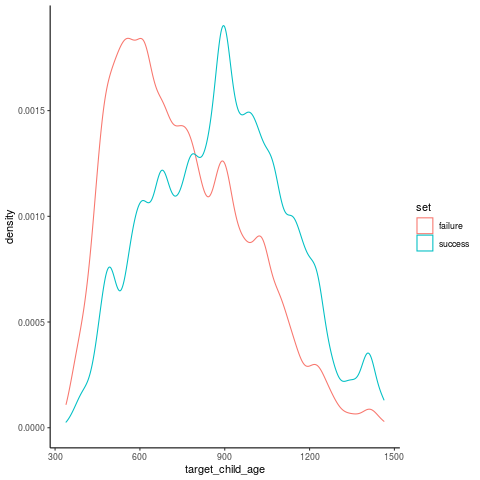

In [70]:
%%R
ggplot(utts_with_ages) + geom_density(aes(x=target_child_age, color=set)) + theme_classic()

In [72]:
utts_with_ages['year'] = .5*np.floor(utts_with_ages['target_child_age'] / (365. /2) ) 

In [73]:
utts_with_ages.loc[utts_with_ages.set == 'failure'].year.value_counts()

1.5    9919
2.0    7261
1.0    6693
2.5    4895
3.0    2097
3.5     414
0.5     167
4.0      11
Name: year, dtype: int64

In [ ]:
utts_with_ages.loc[utts_with_ages.set == 'success'].year.value_counts()

In [352]:
models = [
{'title': 'CHILDES BERT, +-20 utts context',
 'kwargs': {'modelLM': ft1_bertMaskedLM,
            'tokenizer': ft1_tokenizer,
            'softmax_mask': ft1_softmax_mask,
            'num_context_utts': 20,
            'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'CHILDES BERT, same utt only',
 'kwargs': {'modelLM': ft1_bertMaskedLM,
            'tokenizer': ft1_tokenizer,
            'softmax_mask': ft1_softmax_mask,
            'num_context_utts': 0,
            'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'Adult BERT, +-20 utts context',
'kwargs': {'modelLM': adult_bertMaskedLM,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'num_context_utts': 20,
           'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'Adult BERT, same utt only',
'kwargs': {'modelLM': adult_bertMaskedLM,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'num_context_utts': 0,
           'use_speaker_labels':False
           },
 'type': 'BERT'
},        
{'title': 'CHILDES Unigram',
'kwargs': {'child_counts_path': 'data/chi_vocab.csv',
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'vocab': initial_vocab
           },
 'type': 'unigram'
},
{'title': 'Flat Unigram',
'kwargs': {'child_counts_path': None,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'vocab': initial_vocab
           },
 'type': 'unigram'
}]



In [372]:
# Sample one model across time
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [373]:
regenerate = True
if regenerate:
    scores_across_time = transfomers_bert_completions.sample_models_across_time(utts_with_ages, 
    all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab)
    scores_across_time.to_pickle('data/scores_across_time.pkl')
else:
    scores_across_time = pd.read_pickle('data/scores_across_time.pkl')

Running models for age 0.5
Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, same utt only...
Computing failure scores
Computing success scores
Running model Adult BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, same utt only...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.0
Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, same utt only...
Computing failure scores
Computing success scores
Running model Adult BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, same utt only...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.5
Running model CHILDES BER

In [381]:
scores_across_time.loc[(scores_across_time.model == 'CHILDES BERT, +-20 utts context') & 
(scores_across_time.set == 'success')]

,rank,prob,entropy,num_tokens_in_context,bert_token_id,set,mask_position,token,utterance_id,posterior_entropy,...,highest_prior_words,highest_posterior_probabilities,highest_prior_probabilities,sample_index,model,age,word,Unnamed: 0,count,keep
328939,0.0,0.473027,3.928344,80.0,328939.0,success,0.0,button,16817053.0,2.926344,...,button okay yeah push oh no there pull buttons...,0.21078390303757127 0.19157195880458683 0.1498...,0.47302744 0.10064097 0.08252346 0.03563074 0....,167,"CHILDES BERT, +-20 utts context",0.5,NaN,NaN,NaN,NaN
329086,57.0,0.000767,4.219140,93.0,329086.0,success,0.0,ha,16817073.0,1.056694,...,a cow the oh baby yeah no look there ah,0.6268066925026929 0.2749534121512079 0.058745...,0.29368195 0.22137475 0.12882577 0.03903412 0....,168,"CHILDES BERT, +-20 utts context",0.5,NaN,NaN,NaN,NaN
329087,30.0,0.000638,1.244069,93.0,329087.0,success,1.0,cow,16817073.0,0.735868,...,ha hee ah okay oh sheep look ducks yeah hm,0.8554929235005544 0.046610197629218475 0.0334...,0.88524264 0.021388343 0.015007237 0.006990087...,169,"CHILDES BERT, +-20 utts context",0.5,NaN,NaN,NaN,NaN
329365,0.0,0.847905,1.451012,89.0,329365.0,success,0.0,cow,16817123.0,2.017115,...,cow yeah cows horse oh no sheep okay pig right,0.28663448039583334 0.2602033861147479 0.20511...,0.84790474 0.042868435 0.021511942 0.004288753...,170,"CHILDES BERT, +-20 utts context",0.5,NaN,NaN,NaN,NaN
329874,1.0,0.475786,1.409377,112.0,329874.0,success,0.0,up,16817199.0,0.165978,...,down up yeah oh okay ups over yes there go,0.9713143591063459 0.018933890470217447 0.0059...,0.4899811 0.4757863 0.0052351695 0.0031419646 ...,171,"CHILDES BERT, +-20 utts context",0.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837989,0.0,0.986925,0.181910,29.0,1837989.0,success,3.0,do,17040123.0,0.000344,...,do touch break make want get doing did like stop,0.9999745493242883 9.815018382253417e-06 9.332...,0.9869245 0.0024621633 0.0005203182 0.00048553...,959,"CHILDES BERT, +-20 utts context",4.0,NaN,NaN,NaN,NaN
1837990,0.0,0.815126,0.957746,29.0,1837990.0,success,4.0,it,17040123.0,0.299509,...,it that this dat them these bunny him somethin...,0.947533683665135 0.03127494571796182 0.006859...,0.81512606 0.1447699 0.026904609 0.001175711 0...,960,"CHILDES BERT, +-20 utts context",4.0,NaN,NaN,NaN,NaN
1839757,0.0,0.963806,0.276595,11.0,1839757.0,success,0.0,good,17040359.0,0.015969,...,good night bye nice okay late bad great last q...,0.9985893484768282 0.00020933078733868676 7.29...,0.96380645 0.031260014 0.00072495796 0.0004461...,961,"CHILDES BERT, +-20 utts context",4.0,NaN,NaN,NaN,NaN
1839758,0.0,0.984041,0.170109,11.0,1839758.0,success,1.0,night,17040359.0,0.000605,...,night morning day bye nights bed sleep nightti...,0.9999517331041138 2.945393805581083e-05 8.404...,0.98404133 0.008545194 0.002036809 0.000922096...,962,"CHILDES BERT, +-20 utts context",4.0,NaN,NaN,NaN,NaN


In [375]:
scores_across_time.model.value_counts()

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CHILDES BERT, same utt only        20576
Adult BERT, same utt only          20576
Adult BERT, +-20 utts context      20576
CHILDES Unigram                    20576
Flat Unigram                       20576
CHILDES BERT, +-20 utts context    20576
Name: model, dtype: int64

In [382]:
successes_across_time = scores_across_time.loc[scores_across_time.set == 
    'success'][['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age']]
%R -i successes_across_time
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   age                           model posterior_surprisal_mean
1  0.5   Adult BERT, +-20 utts context                2.3319557
2  0.5       Adult BERT, same utt only                5.1606237
3  0.5 CHILDES BERT, +-20 utts context                1.2343716
4  0.5     CHILDES BERT, same utt only                3.3271563
5  0.5                 CHILDES Unigram                3.6790926
6  0.5                    Flat Unigram                4.4973854
7  1.5   Adult BERT, +-20 utts context                1.7073404
8  1.5       Adult BERT, same utt only                3.0065727
9  1.5 CHILDES BERT, +-20 utts context                1.0648574
10 1.5     CHILDES BERT, same utt only                2.0572095
11 1.5                 CHILDES Unigram                3.4367930
12 1.5                    Flat Unigram                4.2272941
13 1.0   Adult BERT, +-20 utts context                2.8155437
14 1.0       Adult BERT, same utt only                4.9641754
15 1.0 CHILDES BERT, +-20 utts context  

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,"Adult BERT, +-20 utts context",2.331956,0.274977
2,0.5,"Adult BERT, same utt only",5.160624,0.476691
3,0.5,"CHILDES BERT, +-20 utts context",1.234372,0.191530
4,0.5,"CHILDES BERT, same utt only",3.327156,0.361603
5,0.5,CHILDES Unigram,3.679093,0.354573
6,0.5,Flat Unigram,4.497385,0.331558
7,1.5,"Adult BERT, +-20 utts context",1.707340,0.074041
8,1.5,"Adult BERT, same utt only",3.006573,0.090872
9,1.5,"CHILDES BERT, +-20 utts context",1.064857,0.059180
10,1.5,"CHILDES BERT, same utt only",2.057209,0.076315


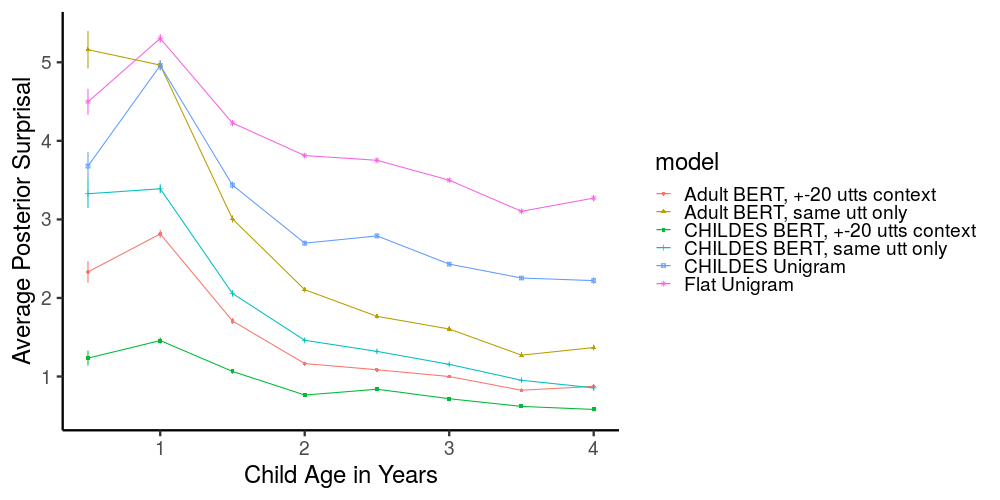

In [384]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

In [385]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,"Adult BERT, +-20 utts context",3.707323,0.201515
2,0.5,"Adult BERT, same utt only",6.399003,0.396100
3,0.5,"CHILDES BERT, +-20 utts context",1.419808,0.178949
4,0.5,"CHILDES BERT, same utt only",3.852227,0.274316
5,0.5,CHILDES Unigram,6.289717,0.096498
6,0.5,Flat Unigram,8.975124,0.000000
7,1.5,"Adult BERT, +-20 utts context",3.539092,0.087803
8,1.5,"Adult BERT, same utt only",6.009203,0.097730
9,1.5,"CHILDES BERT, +-20 utts context",2.259146,0.076348
10,1.5,"CHILDES BERT, same utt only",4.340003,0.080877


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


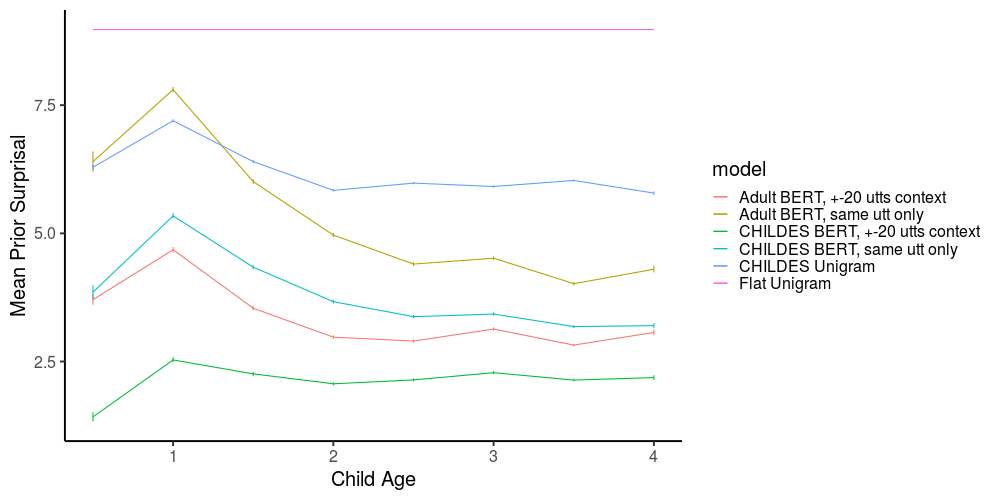

In [386]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [387]:
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal','model','set','age']]
%R -i scores_across_time_short
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,"Adult BERT, +-20 utts context",failure,3.140225,0.082138
2,0.5,"Adult BERT, +-20 utts context",success,1.321636,0.099834
3,0.5,"Adult BERT, same utt only",failure,3.422119,0.078621
4,0.5,"Adult BERT, same utt only",success,1.768958,0.111789
5,0.5,"CHILDES BERT, +-20 utts context",failure,2.611891,0.093699
...,...,...,...,...,...
92,4.0,"CHILDES BERT, same utt only",success,0.833137,0.033435
93,4.0,CHILDES Unigram,failure,2.854018,0.227300
94,4.0,CHILDES Unigram,success,2.079981,0.037202
95,4.0,Flat Unigram,failure,5.122522,0.232140


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


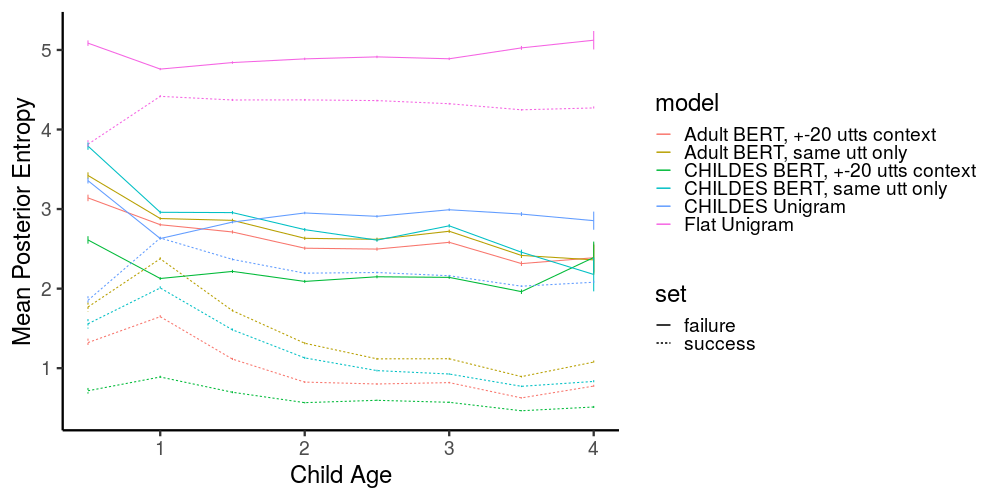

In [388]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

In [389]:
%R mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
%R names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
%R mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model, \
        successes_across_time, sem)
%R names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
%R mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 
%R print(mean_kl_flat_to_prior_by_age)

   age                           model kl_flat_to_prior kl_flat_to_prior_sem
1  0.5   Adult BERT, +-20 utts context         3.341584           0.07084019
2  0.5       Adult BERT, same utt only         3.937513           0.16376119
3  0.5 CHILDES BERT, +-20 utts context         6.583356           0.13992930
4  0.5     CHILDES BERT, same utt only         5.448375           0.30733867
5  0.5                 CHILDES Unigram         3.812681           0.00000000
6  0.5                    Flat Unigram         0.000000           0.00000000
7  1.5   Adult BERT, +-20 utts context         5.103261           0.06103812
8  1.5       Adult BERT, same utt only         4.206501           0.05629478
9  1.5 CHILDES BERT, +-20 utts context         7.226584           0.05897127
10 1.5     CHILDES BERT, same utt only         4.940415           0.06926248
11 1.5                 CHILDES Unigram         3.812681           0.00000000
12 1.5                    Flat Unigram         0.000000           0.00000000

,age,model,kl_flat_to_prior,kl_flat_to_prior_sem
1,0.5,"Adult BERT, +-20 utts context",3.341584,0.070840
2,0.5,"Adult BERT, same utt only",3.937513,0.163761
3,0.5,"CHILDES BERT, +-20 utts context",6.583356,0.139929
4,0.5,"CHILDES BERT, same utt only",5.448375,0.307339
5,0.5,CHILDES Unigram,3.812681,0.000000
6,0.5,Flat Unigram,0.000000,0.000000
7,1.5,"Adult BERT, +-20 utts context",5.103261,0.061038
8,1.5,"Adult BERT, same utt only",4.206501,0.056295
9,1.5,"CHILDES BERT, +-20 utts context",7.226584,0.058971
10,1.5,"CHILDES BERT, same utt only",4.940415,0.069262


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


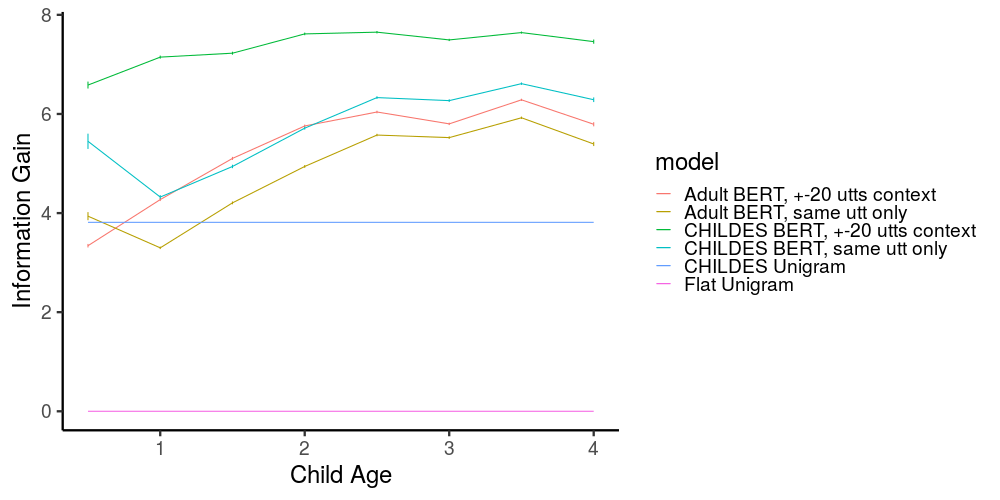

In [390]:
%%R -w 1000 -h 500
ggplot(mean_kl_flat_to_prior_by_age) + geom_line(aes(x=age, 
y=kl_flat_to_prior, color=model)
) + geom_errorbar(aes(x=age, ymin=kl_flat_to_prior - .5*kl_flat_to_prior_sem, 
ymax=kl_flat_to_prior + .5*kl_flat_to_prior_sem, color=model), width=0) + theme_classic(
base_size=24) + ylab('Information Gain') + xlab('Child Age')

In [392]:
%R mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
%R names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
%R mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, \
        successes_across_time, sem)
%R names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
%R mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, \
    mean_kl_flat_to_posterior_by_age_sem) 
%R print(mean_kl_flat_to_posterior_by_age)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   age                           model kl_flat_to_posterior
1  0.5   Adult BERT, +-20 utts context            12.754886
2  0.5       Adult BERT, same utt only            13.487801
3  0.5 CHILDES BERT, +-20 utts context            17.186587
4  0.5     CHILDES BERT, same utt only            15.711973
5  0.5                 CHILDES Unigram            11.990725
6  0.5                    Flat Unigram             6.310929
7  1.5   Adult BERT, +-20 utts context            14.078153
8  1.5       Adult BERT, same utt only            12.010514
9  1.5 CHILDES BERT, +-20 utts context            16.838939
10 1.5     CHILDES BERT, same utt only            13.464265
11 1.5                 CHILDES Unigram            11.657317
12 1.5                    Flat Unigram             6.058814
13 1.0   Adult BERT, +-20 utts context            12.005260
14 1.0       Adult BERT, same utt only            10.057116
15 1.0 CHILDES BERT, +-20 utts context            15.672078
16 1.0     CHILDES BERT, same utt only  

,age,model,kl_flat_to_posterior,kl_flat_to_posterior_sem
1,0.5,"Adult BERT, +-20 utts context",12.754886,0.229214
2,0.5,"Adult BERT, same utt only",13.487801,0.429796
3,0.5,"CHILDES BERT, +-20 utts context",17.186587,0.341916
4,0.5,"CHILDES BERT, same utt only",15.711973,0.545143
5,0.5,CHILDES Unigram,11.990725,0.115527
6,0.5,Flat Unigram,6.310929,0.067508
7,1.5,"Adult BERT, +-20 utts context",14.078153,0.114576
8,1.5,"Adult BERT, same utt only",12.010514,0.103390
9,1.5,"CHILDES BERT, +-20 utts context",16.838939,0.114857
10,1.5,"CHILDES BERT, same utt only",13.464265,0.115971


In [426]:
%%R
names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)

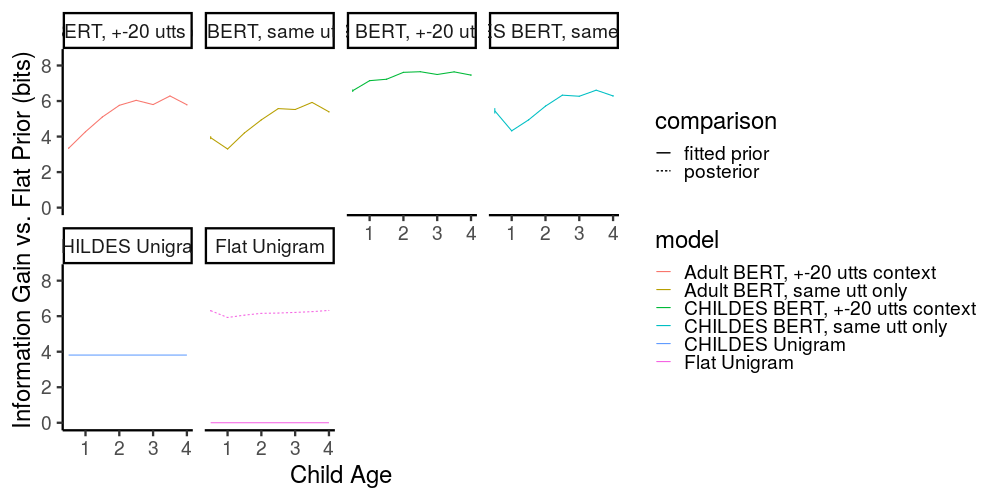

In [427]:
%%R -w 1000 -h 500
ggplot(kls) + geom_line(aes(x=age, y=gain, color=model, linetype=comparison)
) + geom_errorbar(aes(x=age, ymin=gain - .5*gain_sem, 
ymax=gain + .5*gain_sem, color=model, linetype=comparison), width=0) + theme_classic(
base_size=24) + ylab('Information Gain vs. Flat Prior (bits)') + xlab('Child Age'
) + coord_cartesian(ylim=c(0,8.5)) + facet_wrap(~model, ncol=4)

# check units, add posterior for the flat prior

In [428]:
%%R
kls_posteriors = subset(kls, comparison == 'posterior')
kls_priors = subset(kls, comparison == 'fitted prior')
kls_priors$prior_gain = kls_priors$gain
kls_posteriors = merge(kls_posteriors,  kls_priors[,c('age','model','prior_gain')],
    on = c('age','model'))
kls_posteriors$gain = kls_posteriors$gain - kls_posteriors$prior_gain
kls_stacked = rbind(kls_priors, kls_posteriors)
kls_stacked


   age                           model      gain   gain_sem NA_character_
49 0.5   Adult BERT, +-20 utts context  3.341584 0.07084019  fitted prior
50 0.5       Adult BERT, same utt only  3.937513 0.16376119  fitted prior
51 0.5 CHILDES BERT, +-20 utts context  6.583356 0.13992930  fitted prior
52 0.5     CHILDES BERT, same utt only  5.448375 0.30733867  fitted prior
53 0.5                 CHILDES Unigram  3.812681 0.00000000  fitted prior
54 0.5                    Flat Unigram  0.000000 0.00000000  fitted prior
55 1.5   Adult BERT, +-20 utts context  5.103261 0.06103812  fitted prior
56 1.5       Adult BERT, same utt only  4.206501 0.05629478  fitted prior
57 1.5 CHILDES BERT, +-20 utts context  7.226584 0.05897127  fitted prior
58 1.5     CHILDES BERT, same utt only  4.940415 0.06926248  fitted prior
59 1.5                 CHILDES Unigram  3.812681 0.00000000  fitted prior
60 1.5                    Flat Unigram  0.000000 0.00000000  fitted prior
61 1.0   Adult BERT, +-20 utts context

73 fitted prior fitted prior   5.757922
74 fitted prior fitted prior   4.940986
75 fitted prior fitted prior   7.615681
76 fitted prior fitted prior   5.713607
77 fitted prior fitted prior   3.812681
78 fitted prior fitted prior   0.000000
79 fitted prior fitted prior   6.285418
80 fitted prior fitted prior   5.923261
81 fitted prior fitted prior   7.642441
82 fitted prior fitted prior   6.611655
83 fitted prior fitted prior   3.812681
84 fitted prior fitted prior   0.000000
85 fitted prior fitted prior   5.800260
86 fitted prior fitted prior   5.522830
87 fitted prior fitted prior   7.494245
88 fitted prior fitted prior   6.269277
89 fitted prior fitted prior   3.812681
90 fitted prior fitted prior   0.000000
91 fitted prior fitted prior   5.792048
92 fitted prior fitted prior   5.394080
93 fitted prior fitted prior   7.459820
94 fitted prior fitted prior   6.287433
95 fitted prior fitted prior   3.812681
96 fitted prior fitted prior   0.000000
1     posterior    posterior   3.341584


In [429]:
%%R
kls_stacked$comparison = factor(kls_stacked$comparison, c('posterior','fitted prior'))
kls$comparison = factor(kls$comparison, c('posterior','fitted prior'))
kls$age_in_months = round(kls$age * 12)
kls_stacked$age_in_months = round(kls$age * 12)

In [430]:
%%R
library(plyr)
levels(as.factor(kls_stacked$model))

model_levels = c("CHILDES BERT, +-20 utts context", "CHILDES BERT, same utt only", 
           "Adult BERT, +-20 utts context",  "Adult BERT, same utt only",
            "CHILDES Unigram", "Flat Unigram")
model_new_levels =  c("CHILDES BERT, +-20 utts context"="CHILDES BERT\n+-20 utts context",
            "CHILDES BERT, same utt only" = "CHILDES BERT\nsame utt only",
          "Adult BERT, +-20 utts context" = "Adult BERT\n+-20 utts context",
          "Adult BERT, same utt only" = "Adult BERT\nsame utt only"
)
kls_stacked$model = factor(kls_stacked$model, model_levels)
kls_stacked$model = revalue(kls_stacked$model, model_new_levels)

kls$model = factor(kls$model, model_levels)
kls$model = revalue(kls$model, model_new_levels)


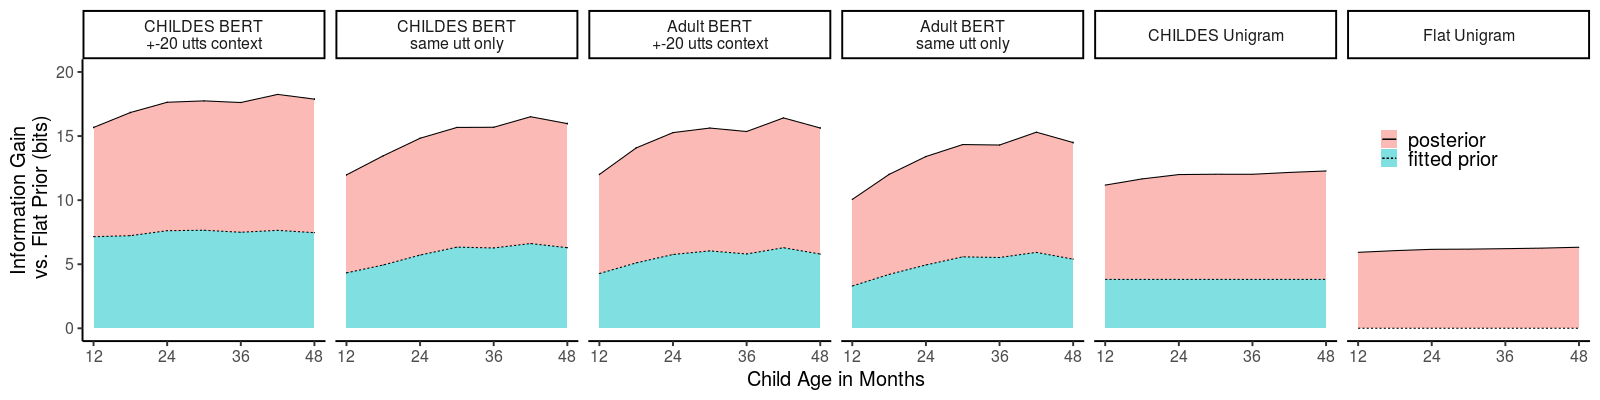

In [436]:
%%R -w 1600 -h 400
year_intervals_in_months = c(12,24,36,48)
p1 = ggplot(subset(kls_stacked, age_in_months >= 12)) + geom_area(aes(x=age_in_months, y=gain, fill=comparison), 
alpha = .5) + theme_classic(
base_size=20) + ylab('Information Gain\n vs. Flat Prior (bits)') + xlab('Child Age in Months'
) + coord_cartesian(ylim=c(0,20)) + facet_wrap(~model, ncol=6)   + geom_line(data=subset(kls, age_in_months >= 12), aes(x=age_in_months, y=gain, linetype=comparison)
) + geom_errorbar(data=subset(kls, age_in_months >= 12), aes(x=age_in_months, ymin=gain - .5*gain_sem, 
ymax=gain + .5*gain_sem, linetype=comparison), width=0) + theme(legend.position = c(0.9, 0.7),
legend.title = element_blank(), 
legend.background = element_blank(), legend.text = element_text(size=20)) + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
print(p1)
ggsave('figures/information_gain.pdf', width=18, height=3)
# check units, add posterior for the flat prior

In [ ]:
%%R
# plot posterior comparison: successes vs. failures 
names(scores_across_time_short)

In [ ]:
%%R -w 1500 -h 500
ggplot(subset(scores_across_time_short, model !='Flat Unigram')) + geom_density(aes(x=posterior_entropy, fill=set),
alpha = .5) + facet_wrap(~model) + theme_classic(base_size =24) + coord_cartesian(ylim=c(0,5))

In [ ]:
# prior entropies need to be re-calculated on the next run

In [ ]:
%%R -w 1500 -h 500
ggplot(subset(scores_across_time_short, model !='Flat Unigram')) + geom_density(aes(x=prior_entropy, fill=set),
alpha = .5) + facet_wrap(~model) + theme_classic(base_size =24) + coord_cartesian(ylim=c(0,5))

# ROC for Completions 

In [ ]:
# split by model and get an ROC for each

In [444]:
%%R
library(plotROC)

R[write to console]: 
Attaching package: ‘plotROC’


R[write to console]: The following object is masked from ‘package:pROC’:

    ggroc




In [ ]:
%%R 
unituqscores_across_time_short$set

In [445]:
%%R 
# replicate colors and shapes from ggplot
# by_model = split(scores_across_time_short, scores_across_time_short$model)
# plot(roc(set ~ posterior_entropy, by_model[[1]]))
# for (single_model in by_model[2:length(by_model)]){
#     plot(roc(set ~ posterior_entropy, single_model), add=T)
# }
ggplot(scores_across_time_short, aes(d=set, M=model)) + geom_roc()

R[write to console]: Error: stat_roc requires the following missing aesthetics: m
Run `rlang::last_error()` to see where the error occurred.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In verify_d(data$d) :
R[write to console]: 
 
R[write to console]:  D not labeled 0/1, assuming failure = 0 and success = 1!



RRuntimeError: Error: stat_roc requires the following missing aesthetics: m
Run `rlang::last_error()` to see where the error occurred.


# Review Posteriors

### Find new test examples- successes

In [76]:
success_utts_with_gloss = success_utts.merge(utt_glosses[['id','gloss']], left_on=['utterance_id'], right_on=['id'])
success_utts_with_gloss['num_tokens'] = [len(x.split(' ')) for x in success_utts_with_gloss['gloss']]
' | '.join(success_utts_with_gloss.loc[success_utts_with_gloss.num_tokens ==4 ].gloss)

"pop pop pop pop | another one another one | I don't want to | apple apple apple apple | a red a pink | oh A B c | Mom what is that | a green a blue | beep beep beep beep | a b a b | one two three four | did you did you | one two one two | one two one two | b e a o | what is this two | no no no no | a cars a cars | a two a two | beep beep beep beep | one two one one | a tree a tree | way up over there | Mom Mommy Mom Mommy | where's Daddy where's Dada | hi Gigi hi Gigi | a ball a ball | a four a four | another one another one | mah mah mah mah | what's that what's this | what's that a ball | five five five five | no no Mommy no | mah muh mm mm | one one two three | a green a green | a green a green | a square a square | I did a square | another one another one | no no no no | no no no no | another one another one | a ball a ball | a ball a ball | red circle what's that | a ball a ball | a four a five | Mommy I did it | look at the green | Mommy can you fix | I try to push | Mommy help 

In [77]:
selected = success_utts_with_gloss.loc[success_utts_with_gloss.gloss=='I want to read'].utterance_id 

In [78]:
all_tokens_phono.columns

Index(['token', 'id', 'gloss', 'transcript_id', 'utterance_order',
       'speaker_code', 'type', 'punct', 'speaker_code_simple',
       'gloss_with_punct', 'token_id', 'seq_utt_id', 'actual_phonology',
       'model_phonology', 'target_child_age', 'bert_token_id',
       'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw',
       'cv_collapsed', 'num_vowels', 'in_vocab', 'success_token', 'yyy_token',
       'partition'],
      dtype='object')

In [79]:
selected

23653    16928243
24502    16933485
24597    16934000
31052    16962364
Name: utterance_id, dtype: int64

In [161]:
all_tokens_phono.loc[all_tokens_phono.id.isin(selected)][['gloss','actual_phonology_no_dia',
 'model_phonology_no_dia', 'id','bert_token_id','utterance_order','transcript_id']]

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,gloss,actual_phonology_no_dia,model_phonology_no_dia,id,bert_token_id,utterance_order,transcript_id
1032327,I want to read,,,16928243,1032327,310,42336
1032328,I want to read,ɑə,ɑə,16928243,1032328,310,42336
1032329,I want to read,wɑn,wɑnt,16928243,1032329,310,42336
1032330,I want to read,də,tu,16928243,1032330,310,42336
1032331,I want to read,wid,ɹid,16928243,1032331,310,42336
1032332,I want to read,,,16928243,1032332,310,42336
1067443,I want to read,,,16933485,1067443,631,42336
1067444,I want to read,ɑə,ɑə,16933485,1067444,631,42336
1067445,I want to read,wɑn,wɑnt,16933485,1067445,631,42336
1067446,I want to read,də,tu,16933485,1067446,631,42336


In [238]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [318]:
scores_across_models = transfomers_bert_completions.sample_across_models([16928243], success_utts,
    yyy_utts, all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab, beta_values=[3.2])

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, no utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, no context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...


In [319]:
success_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES BERT, 40 utts context') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'play (0.13) go (0.11) eat (0.06) see (0.05) talk (0.04) come (0.03) cry (0.02) hide (0.02) sleep (0.02) get (0.02)'

In [320]:
success_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES BERT, 40 utts context') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'eat (0.21) see (0.16) weed (0.15) feed (0.1) read (0.06) walk (0.04) pee (0.03) wee (0.02) watch (0.02) hear (0.02)'

In [321]:
success_example = scores_across_models.loc[(scores_across_models.model == 'Adult BERT, 40 utts context') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'cry (0.21) scream (0.17) die (0.08) laugh (0.06) run (0.05) know (0.05) stay (0.02) smile (0.02) leave (0.02) vomit (0.01)'

In [322]:
words = success_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'weep (0.6) feed (0.17) leave (0.06) be (0.02) win (0.01) eat (0.01) die (0.01) watch (0.01) laugh (0.01) see (0.01)'

In [323]:
success_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES Unigram') &
    (scores_across_models.token == 'read')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
success_example

words = success_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'i (0.04) a (0.03) the (0.03) yeah (0.03) it (0.02) no (0.02) you (0.02) and (0.02) that (0.02) this (0.01)'

In [324]:
words = success_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in success_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'we (0.34) need (0.11) and (0.06) would (0.04) wee (0.04) one (0.03) what (0.03) weed (0.02) he (0.02) me (0.02)'

In [325]:
 utt_glosses.loc[(utt_glosses.transcript_id == target_transcript_id) &
                (utt_glosses.utterance_order.isin(range(310-2, 310+2)))]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
168425,yyy yyy,42336,16928205,308,CHI,declarative,.,[CHI],[CHI] yyy yyy.
168445,you want mamma let's see,42336,16928225,309,MOT,declarative,.,[CGV],[CGV] you want mamma let's see.
168463,I want to read,42336,16928243,310,CHI,declarative,.,[CHI],[CHI] i want to read.
168481,okay mommy's gonna pick out a book,42336,16928261,311,MOT,declarative,.,[CGV],[CGV] okay mommy's gonna pick out a book.


### Find new Test Example -- Failures

In [326]:
yyy_utts_with_gloss = yyy_utts.merge(utt_glosses[['id','gloss']], left_on=['utterance_id'], right_on=['id'])
yyy_utts_with_gloss['num_tokens'] = [len(x.split(' ')) for x in yyy_utts_with_gloss['gloss']]
' | '.join(yyy_utts_with_gloss.loc[success_utts_with_gloss.num_tokens ==4 ].gloss)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy train | yyy | yyy | yyy | yyy where the pink | yyy | yyy | yyy | yyy heart | yyy | yyy | yyy | yyy | yyy | yyy | no yyy | yyy | yyy | yyy | yyy | yyy | green yellow red yyy | yyy | yyy | yyy | yyy | yyy | yyy Mommy | yyy | yyy | yyy | yyy no | yyy | yyy | a yyy | eight yyy three | yyy please | yyy | yyy | yyy | yyy egg | yyy | yyy | yyy | yyy | yyy | yyy | yyy | yyy a blue | yyy | yyy Mommy | yyy | yyy three | yyy | yyy | yyy | yyy six | yyy | yyy | yyy | yyy | um yyy | yyy my Bob | yyy two | yyy | yyy | yyy | green ball yyy | yyy | yyy | yyy please scoot over | where's the flower and the yyy | yyy | yyy | yyy | yyy put it right there | yyy more | yyy color | yyy | yyy | oh yyy two three | yyy | yyy butterfly | where's Wiggle yyy | yyy where are you | yyy | where's the yyy | yyy | yyy | yyy | yyy | yyy see em | yyy | they match yyy | yyy | yyy | yyy | taking off my yyy off | yyy | yyy Gigi | they e

In [327]:
selected = yyy_utts_with_gloss.loc[yyy_utts_with_gloss.gloss=='you make your yyy'].utterance_id 

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [328]:
all_tokens_phono.loc[all_tokens_phono.id.isin(selected)][['gloss','actual_phonology_no_dia',
 'model_phonology_no_dia', 'id','bert_token_id','utterance_order','transcript_id']]

,gloss,actual_phonology_no_dia,model_phonology_no_dia,id,bert_token_id,utterance_order,transcript_id
307933,you make your yyy,,,16813515,307933,112,42253
307934,you make your yyy,ju,ju,16813515,307934,112,42253
307935,you make your yyy,meək,meək,16813515,307935,112,42253
307936,you make your yyy,jɜ,jɑɹ,16813515,307936,112,42253
307937,you make your yyy,fɜt,*,16813515,307937,112,42253
307938,you make your yyy,,,16813515,307938,112,42253


In [329]:
scores_across_models = transfomers_bert_completions.sample_across_models( [16813515], success_utts,
    yyy_utts, all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab, beta_values=[3.2])

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, no utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, no context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...


In [330]:
scores_across_models

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank,prob,entropy,num_tokens_in_context,bert_token_id,set,posterior_entropy,prior_entropy,position_in_mask,kl_flat_to_prior,...,edit_distance,highest_posterior_words,highest_prior_words,highest_posterior_probabilities,highest_prior_probabilities,sample_index,beta_value,model,token,keep
307937,NaN,NaN,7.375654,6.0,307937.0,failure,3.123939,5.112414,NaN,NaN,...,NaN,feet hat own fit food bed mess way fat foot,own house bed mess way name tower head face br...,0.3463317245169062 0.13202393990779232 0.08789...,0.13597743 0.071731165 0.046943206 0.040938225...,0,3.2,"CHILDES BERT, 40 utts context",NaN,NaN
307937,NaN,NaN,7.375654,6.0,307937.0,failure,3.123939,5.112414,NaN,NaN,...,NaN,feet hat own fit food bed mess way fat foot,own house bed mess way name tower head face br...,0.3463317245169062 0.13202393990779232 0.08789...,0.13597743 0.071731165 0.046943206 0.040938225...,0,3.2,"CHILDES BERT, no utts context",NaN,NaN
307937,NaN,NaN,3.315662,6.0,307937.0,failure,3.679561,2.298241,NaN,NaN,...,NaN,move bet choice point own shot day cut bed call,choice point choices move own rounds day mark ...,0.13505124487938147 0.10169419593253419 0.0698...,0.3847465 0.2974154 0.09422047 0.03033365 0.01...,0,3.2,"Adult BERT, 40 utts context",NaN,NaN
307937,NaN,NaN,3.315662,6.0,307937.0,failure,3.679561,2.298241,NaN,NaN,...,NaN,move bet choice point own shot day cut bed call,choice point choices move own rounds day mark ...,0.13505124487938147 0.10169419593253419 0.0698...,0.3847465 0.2974154 0.09422047 0.03033365 0.01...,0,3.2,"Adult BERT, no context",NaN,NaN
307937,NaN,NaN,5.862046,NaN,307937.0,failure,3.809099,5.862046,NaN,NaN,...,NaN,it that fit what feet not foot get got put,i a the yeah it no you and that this,0.1528414008742849 0.1094394622717476 0.060582...,0.04169577290443618 0.03267180603396187 0.0277...,0,3.2,CHILDES Unigram,yyy,True
307937,NaN,NaN,8.975124,NaN,307937.0,failure,5.367228,8.975124,NaN,NaN,...,NaN,fought fit foot fat feet act sheet root sit met,stalks blake sad scent fur sessions refer rare...,0.07104101998497513 0.07104101998497513 0.0710...,0.00012651821862348178 0.00012651821862348178 ...,0,3.2,Flat Unigram,yyy,True


In [331]:
yyy_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES BERT, 40 utts context')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
yyy_example

words = yyy_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'own (0.14) house (0.07) bed (0.05) mess (0.04) way (0.03) name (0.03) tower (0.03) head (0.02) face (0.02) breakfast (0.02)'

In [332]:
words = yyy_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'feet (0.35) hat (0.13) own (0.09) fit (0.04) food (0.04) bed (0.03) mess (0.03) way (0.02) fat (0.02) foot (0.01)'

In [333]:
yyy_example = scores_across_models.loc[(scores_across_models.model == 'Adult BERT, 40 utts context')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
yyy_example

words = yyy_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'choice (0.38) point (0.3) choices (0.09) move (0.03) own (0.01) rounds (0.01) day (0.01) mark (0.01) bed (0.01) call (0.01)'

In [334]:
words = yyy_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'move (0.14) bet (0.1) choice (0.07) point (0.05) own (0.05) shot (0.04) day (0.04) cut (0.04) bed (0.04) call (0.04)'

In [335]:
yyy_example = scores_across_models.loc[(scores_across_models.model == 'CHILDES Unigram')][['model','highest_posterior_words','highest_posterior_probabilities',
    'highest_prior_words','highest_prior_probabilities', 'prior_surprisal','token']]
yyy_example

words = yyy_example.iloc[0].highest_prior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_prior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'i (0.04) a (0.03) the (0.03) yeah (0.03) it (0.02) no (0.02) you (0.02) and (0.02) that (0.02) this (0.01)'

In [336]:
words = yyy_example.iloc[0].highest_posterior_words.split(' ')
probs = [float(x) for x in yyy_example.iloc[0].highest_posterior_probabilities.split(' ')]
' '.join([words[i]+' ('+str(np.round(probs[i],2))+')' for i in range(len(words))]) 

'it (0.15) that (0.11) fit (0.06) what (0.06) feet (0.05) not (0.04) foot (0.04) get (0.03) got (0.03) put (0.03)'

In [181]:
 utt_glosses.loc[(utt_glosses.transcript_id == 42253) &
                (utt_glosses.utterance_order.isin(range(112-3, 112+3)))]

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
53679,then we won't be able to put them back into th...,42253,16813459,109,MOT,declarative,.,[CGV],[CGV] then we won't be able to put them back i...
53702,do you want ta put some beans in your eggs and...,42253,16813482,110,MOT,question,?,[CGV],[CGV] do you want ta put some beans in your eg...
53721,no,42253,16813501,111,CHI,declarative,.,[CHI],[CHI] no.
53735,you make your yyy,42253,16813515,112,CHI,declarative,.,[CHI],[CHI] you make your yyy.
53749,can I make one,42253,16813529,113,MOT,question,?,[CGV],[CGV] can i make one?
53774,no,42253,16813554,114,MOT,declarative,.,[CGV],[CGV] no.


# Find the best value $\beta$  for the likelihood

In [245]:
# maximize the posterior by iterating over beta values
success_utts_for_beta_fitting = success_utts.sample(1000, replace=False).utterance_id
success_utts_for_beta_fitting

62405     16962957
123101    17130388
17122     16814250
146027    17202081
101453    17071586
            ...   
139685    17183993
150553    17228827
103068    17076280
109352    17092076
8047      16787584
Name: utterance_id, Length: 1000, dtype: int64

In [274]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [285]:
test_beta_vals = np.arange(2.5,3.5,.1)
beta_results = transfomers_bert_completions.sample_across_models(success_utts_for_beta_fitting, success_utts, yyy_utts, 
    all_tokens_phono, models[0:1], initial_vocab, cmu_in_initial_vocab, beta_values =
                     test_beta_vals)

Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores


In [286]:
beta_results_surp = beta_results.groupby(['beta_value']).posterior_surprisal.agg(lambda x: np.mean(-1 * np.log(x))
).reset_index()
%R -i beta_results_surp

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


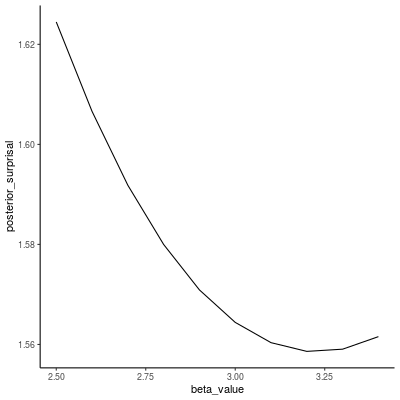

In [287]:
%%R -w 400 -h 400
ggplot(beta_results_surp) + geom_line(aes(x=beta_value, y=posterior_surprisal)) + theme_classic()

In [288]:
beta_results_surp

,beta_value,posterior_surprisal
0,2.5,1.624477
1,2.6,1.606594
2,2.7,1.591827
3,2.8,1.579989
4,2.9,1.570903
5,3.0,1.564409
6,3.1,1.560360
7,3.2,1.558618
8,3.3,1.559059
9,3.4,1.561566
